# Projet Série temporelle




In [ ]:
!pip install arch
import yfinance as yf
import statsmodels.api as sm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import lag_plot
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from scipy.stats import boxcox
from lightgbm import LGBMRegressor
from numpy import polyfit
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import coint
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.tsa.stattools import grangercausalitytests
from arch import arch_model
from statsmodels.tsa.exponential_smoothing.ets import ETSModel



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.0/983.0 kB 4.1 MB/s eta 0:00:00


# Exportation des données

In [ ]:


# Définir le symbole de l'actif (Gold)
ticker_symbol = 'GC=F'

# Définir la période de temps
start_date = '2008-01-01'
end_date = '2024-02-04'

# Télécharger les données historiques depuis Yahoo Finance
gold_data = yf.download(ticker_symbol, start=start_date, end=end_date)

# Exporter les données dans un fichier CSV
gold_data.to_csv('gold_data.csv')

gold_data.head()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2008-01-02,848.700012,857.799988,846.400024,857.000000,857.000000,130
2008-01-03,863.000000,865.500000,856.299988,866.400024,866.400024,181
2008-01-04,861.400024,865.500000,860.200012,863.099976,863.099976,28
2008-01-07,860.900024,860.900024,857.400024,859.599976,859.599976,4
2008-01-08,861.599976,879.400024,861.599976,878.000000,878.000000,21


In [ ]:
gold_data = gold_data[gold_data.Open !=0]
gold_data = gold_data[gold_data.High !=0]
gold_data = gold_data[gold_data.Low !=0]
gold_data = gold_data[gold_data.Close !=0]
gold_data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2008-01-02,848.700012,857.799988,846.400024,857.000000,857.000000,130
2008-01-03,863.000000,865.500000,856.299988,866.400024,866.400024,181
2008-01-04,861.400024,865.500000,860.200012,863.099976,863.099976,28
2008-01-07,860.900024,860.900024,857.400024,859.599976,859.599976,4
2008-01-08,861.599976,879.400024,861.599976,878.000000,878.000000,21
...,...,...,...,...,...,...
2024-01-29,2025.199951,2025.199951,2025.199951,2025.199951,2025.199951,150708
2024-01-30,2032.500000,2048.500000,2028.099976,2031.500000,2031.500000,26907
2024-01-31,2035.400024,2055.000000,2030.000000,2048.399902,2048.399902,2007


# Exploration

In [ ]:
x = pd.Series(gold_data['High'].values, index=pd.date_range("2008-01-1", freq="D", periods=gold_data.shape[0]))



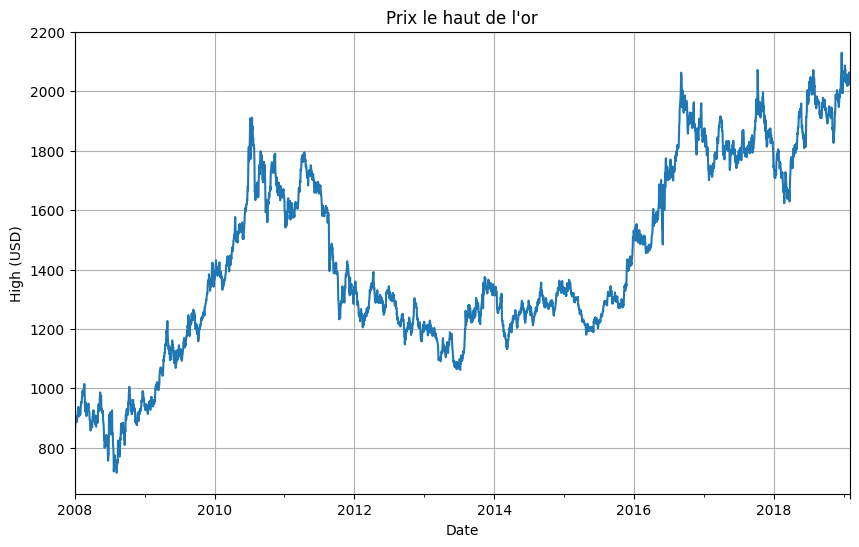

In [ ]:


# Afficher les prix de clôture
plt.figure(figsize=(10, 6))
x.plot()
plt.title('Prix le haut de l\'or')
plt.xlabel('Date')
plt.ylabel('High (USD)')
plt.grid(True)
plt.show()



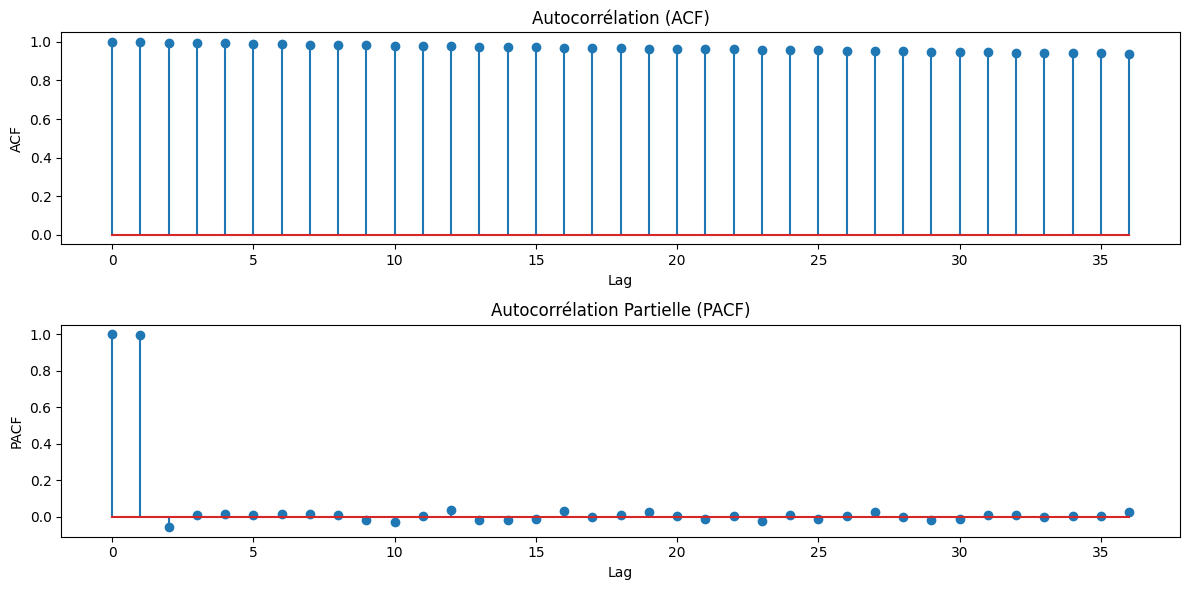

In [ ]:
# Calculer l'ACF et la PACF
acf = sm.tsa.acf(x, fft=False)
pacf = sm.tsa.pacf(x)

# Tracer l'ACF
plt.figure(figsize=(12, 6))
plt.subplot(211)
plt.stem(acf)
plt.title('Autocorrélation (ACF)')
plt.xlabel('Lag')
plt.ylabel('ACF')

# Tracer la PACF
plt.subplot(212)
plt.stem(pacf)
plt.title('Autocorrélation Partielle (PACF)')
plt.xlabel('Lag')
plt.ylabel('PACF')

plt.tight_layout()
plt.show()

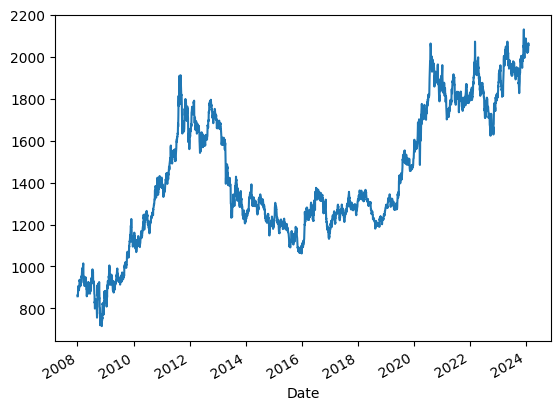

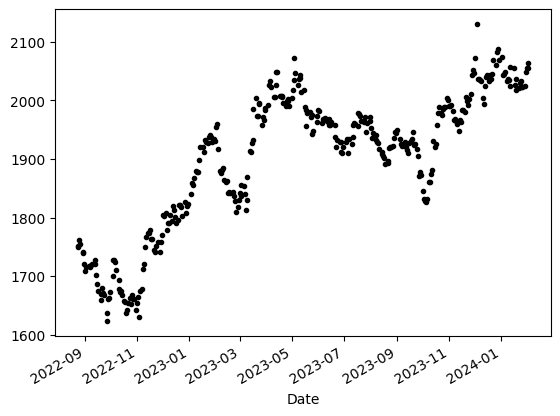

In [ ]:
target_series = gold_data['High']
series_vol = gold_data['Volume']
target_series.plot()
plt.show()
target_series[-365:].plot(style='k.')
plt.show()



# Créer une nouvelle DataFrame avec seulement les colonnes 'High' et 'Volume'
combined_data = gold_data[['High', 'Volume']]

combined_data.to_csv('Cointégration 1')

target_series.to_csv('High.csv')

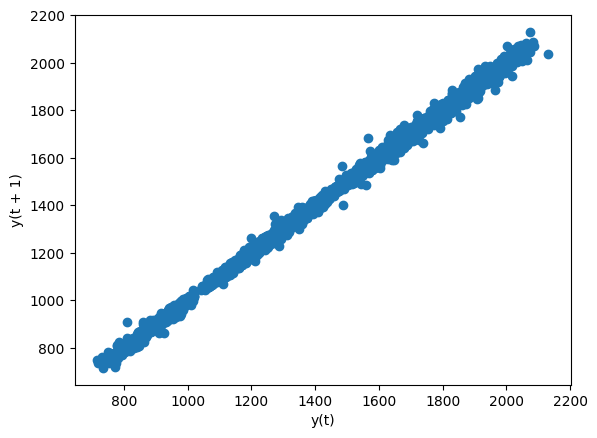

In [ ]:
lag_plot(target_series)
plt.show()



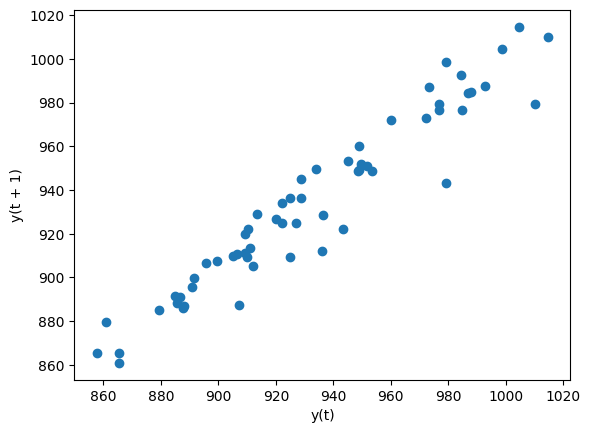

In [ ]:
lag_plot(target_series[:60])
plt.show()

La série temporelle semble présenter une corrélation linéaire forte sur l'ensemble des données, cette corrélation peut varier ou disparaître lorsque on examine des périodes plus courtes de la série temporelle.

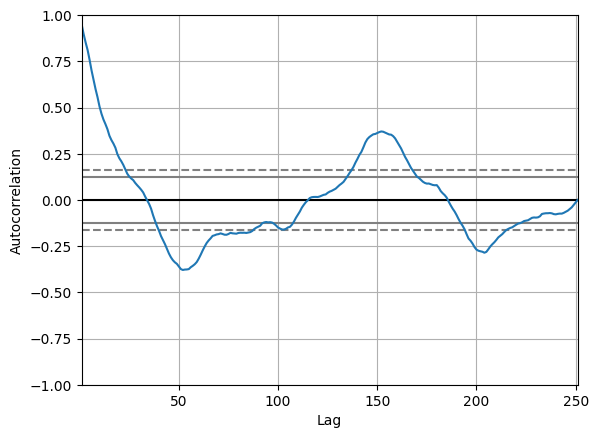

In [ ]:
autocorrelation_plot(target_series['2023'])
plt.show()

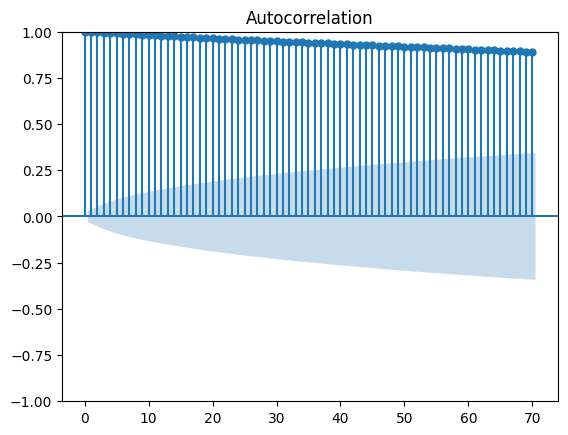

In [ ]:
plot_acf(target_series, lags=70)
plt.show()



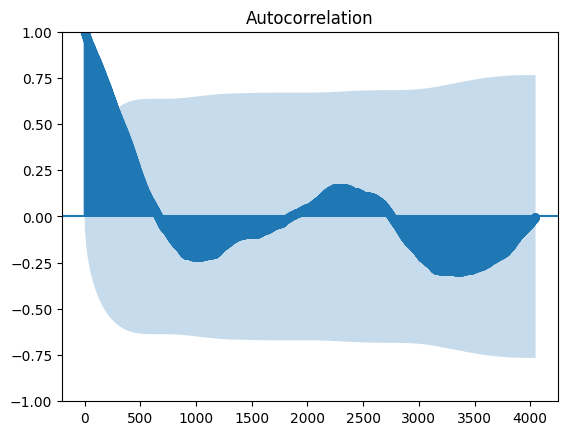

In [ ]:
plot_acf(target_series, lags=target_series.shape[0]-1)
plt.show()



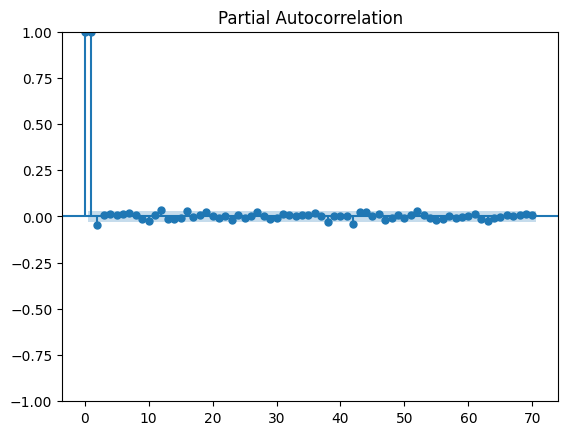

In [ ]:
plot_pacf(target_series, lags=70)
plt.show()

# Pré-traitement: Stationnarité

* Test de Kwiatkowski Phillips Schmidt Shin (test KPSS)

* Test de Dickey-Fuller augmenté

L'intuition derrière ce test est de déterminer à quel point une série temporelle est définie par une tendance.

**Hypothèse nulle (H0)** : En cas de non rejet, cela suggère que la série temporelle a une racine unitaire, ce qui signifie qu'elle est non stationnaire. Elle présente une structure dépendante du temps.

**Hypothèse alternative (H1)**: L'hypothèse nulle est rejetée ; cela suggère que la série temporelle n'a pas de racine unitaire, ce qui signifie qu'elle est stationnaire. Elle ne présente pas de structure dépendante du temps.

Nous interprétons ce résultat en utilisant la valeur p du test. Une valeur p inférieure à un seuil (tel que 5 % ou 1 %) suggère que nous rejetons l'hypothèse nulle (stationnaire), tandis qu'une valeur p supérieure au seuil suggère que nous ne rejetons pas l'hypothèse nulle (non stationnaire).

Valeur p > 0,05 : Non rejet de l'hypothèse nulle (H0), les données ont une racine unitaire et sont non stationnaires.
Valeur p ≤ 0,05 : Rejet de l'hypothèse nulle (H0), les données n'ont pas de racine unitaire et sont stationnaires.

In [ ]:
def check_stationary(series):

    def reverse_dictionary(dictionary):

        reverse = {}
        counter = 0
        for val in list(dictionary.values()):
            reverse[val] = list(dictionary.keys())[counter]
            counter = counter + 1
        return reverse

    check_adf = 0
    result_adf = adfuller(series)
    print('=====ADF Result=====')
    print('ADF Statistic: %f' % result_adf[0])
    print('p-value: %f' % result_adf[1])
    print('Critical Values:')
    for key, value in result_adf[4].items():
        print('\t%s: %.3f' % (key, value))

    if result_adf[1] > 0.05:
        print(result_adf[1],'>',0.05)
        check_adf = check_adf + 1

    max_critical_val_adf = max(list(result_adf[4].values()))
    reverse_adf = reverse_dictionary(result_adf[4])
    if result_adf[0] > max_critical_val_adf:
        print('ADF Statistic: %f' % result_adf[0],'>','Max Critical Values:' ,reverse_adf[max_critical_val_adf],':',max_critical_val_adf)
        check_adf = check_adf + 1

    if check_adf > 0:
        print('By ADF Test, the time series is non_Stationary.')
        print('The Check score:',check_adf)
    else:
        print('By ADF Test, the time series is Stationary.')

    print('=====KPSS Result=====')
    check_kpss = 0
    result_kpss_ct=kpss(series,regression="ct")
    print('KPSS Statistic: %f' %result_kpss_ct[0])
    print('p-value: %f' %result_kpss_ct[1])
    print('Critical values:')
    for key, value in result_kpss_ct[3].items():
        print('\t%s: %.3f' %(key, value))

    if result_kpss_ct[1] < 0.05:
        print(result_kpss_ct[0],'<',0.05)
        check_kpss = check_kpss + 1

    max_critical_val_kpss = max(list(result_kpss_ct[3].values()))
    reverse_kpss = reverse_dictionary(result_kpss_ct[3])
    if result_kpss_ct[0] > max_critical_val_kpss:
        print('ADF Statistic: %f' % result_kpss_ct[0],'>','Max Critical Values:' ,reverse_kpss[max_critical_val_kpss],':',max_critical_val_kpss)
        check_kpss = check_kpss + 1

    if check_kpss > 0:
        print('By KPSS Test, the time series is non_Stationary.')
        print('The Check score:',check_kpss)
    else:
        print('By KPSS Test, the time series is Stationary.')

    print('========Final Result========')
    print('Overall Check Score:',check_kpss+check_adf)

In [ ]:
check_stationary(target_series)

=====ADF Result=====
ADF Statistic: -1.203646
p-value: 0.672025
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567
0.6720253490290113 > 0.05
ADF Statistic: -1.203646 > Max Critical Values: 10% : -2.5671513419192578
By ADF Test, the time series is non_Stationary.
The Check score: 2
=====KPSS Result=====
KPSS Statistic: 1.014607
p-value: 0.010000
Critical values:
	10%: 0.119
	5%: 0.146
	2.5%: 0.176
	1%: 0.216
1.014607180711599 < 0.05
ADF Statistic: 1.014607 > Max Critical Values: 1% : 0.216
By KPSS Test, the time series is non_Stationary.
The Check score: 2
========Final Result========
Overall Check Score: 4


<ipython-input-38-102a32dcca27>:39: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result_kpss_ct=kpss(series,regression="ct")


**Box-Cox test**

D'après tous les tests, les séries ne sont pa sstationnaires après les transformations faites.

reciprocal transformation Lambda: -1.000000


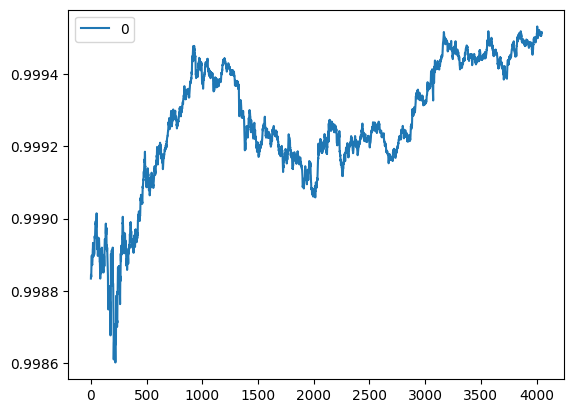

=====ADF Result=====
ADF Statistic: -1.683046
p-value: 0.439868
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567
0.4398680588590007 > 0.05
ADF Statistic: -1.683046 > Max Critical Values: 10% : -2.567152955692979
By ADF Test, the time series is non_Stationary.
The Check score: 2
=====KPSS Result=====
KPSS Statistic: 0.825530
p-value: 0.010000
Critical values:
	10%: 0.119
	5%: 0.146
	2.5%: 0.176
	1%: 0.216
0.8255296426804598 < 0.05
ADF Statistic: 0.825530 > Max Critical Values: 1% : 0.216
By KPSS Test, the time series is non_Stationary.
The Check score: 2
========Final Result========
Overall Check Score: 4
reciprocal sqrt transformation Lambda: -0.500000


<ipython-input-38-102a32dcca27>:39: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result_kpss_ct=kpss(series,regression="ct")


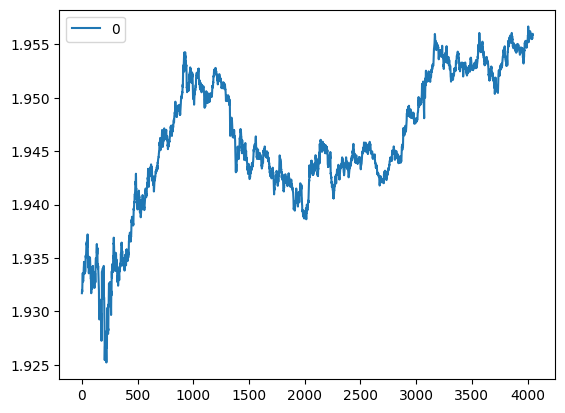

=====ADF Result=====
ADF Statistic: -1.510503
p-value: 0.528309
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567
0.5283091995044634 > 0.05
ADF Statistic: -1.510503 > Max Critical Values: 10% : -2.567152955692979
By ADF Test, the time series is non_Stationary.
The Check score: 2
=====KPSS Result=====
KPSS Statistic: 0.856802
p-value: 0.010000
Critical values:
	10%: 0.119
	5%: 0.146
	2.5%: 0.176
	1%: 0.216
0.8568020663424408 < 0.05
ADF Statistic: 0.856802 > Max Critical Values: 1% : 0.216
By KPSS Test, the time series is non_Stationary.
The Check score: 2
========Final Result========
Overall Check Score: 4
log transformation Lambda: 0.000000


<ipython-input-38-102a32dcca27>:39: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result_kpss_ct=kpss(series,regression="ct")


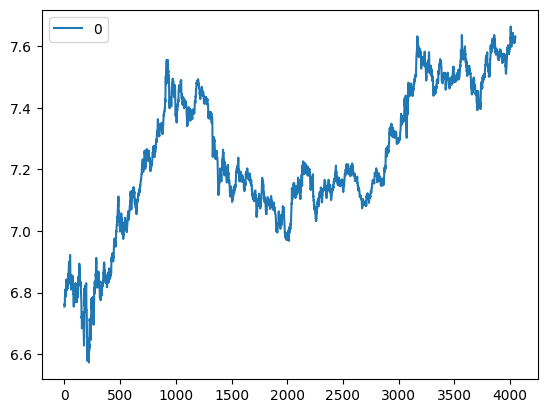

=====ADF Result=====
ADF Statistic: -1.404589
p-value: 0.580074
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567
0.5800738948771824 > 0.05
ADF Statistic: -1.404589 > Max Critical Values: 10% : -2.567152004764292
By ADF Test, the time series is non_Stationary.
The Check score: 2
=====KPSS Result=====
KPSS Statistic: 0.900871
p-value: 0.010000
Critical values:
	10%: 0.119
	5%: 0.146
	2.5%: 0.176
	1%: 0.216
0.9008714858023064 < 0.05
ADF Statistic: 0.900871 > Max Critical Values: 1% : 0.216
By KPSS Test, the time series is non_Stationary.
The Check score: 2
========Final Result========
Overall Check Score: 4
sqrt transformation Lambda: 0.500000


<ipython-input-38-102a32dcca27>:39: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result_kpss_ct=kpss(series,regression="ct")


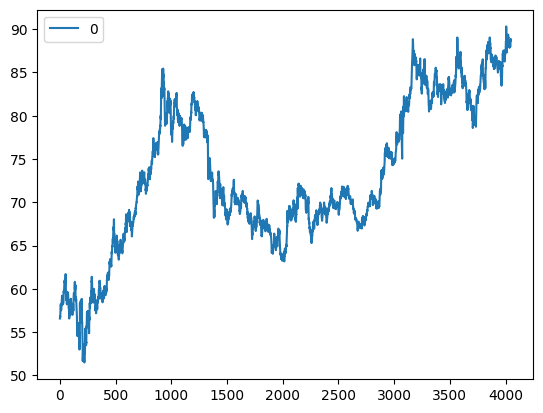

=====ADF Result=====
ADF Statistic: -1.228806
p-value: 0.661083
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567
0.6610832003882684 > 0.05
ADF Statistic: -1.228806 > Max Critical Values: 10% : -2.567152004764292
By ADF Test, the time series is non_Stationary.
The Check score: 2
=====KPSS Result=====
KPSS Statistic: 0.954790
p-value: 0.010000
Critical values:
	10%: 0.119
	5%: 0.146
	2.5%: 0.176
	1%: 0.216
0.9547896914206702 < 0.05
ADF Statistic: 0.954790 > Max Critical Values: 1% : 0.216
By KPSS Test, the time series is non_Stationary.
The Check score: 2
========Final Result========
Overall Check Score: 4
no transform transformation Lambda: 1.000000


<ipython-input-38-102a32dcca27>:39: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result_kpss_ct=kpss(series,regression="ct")


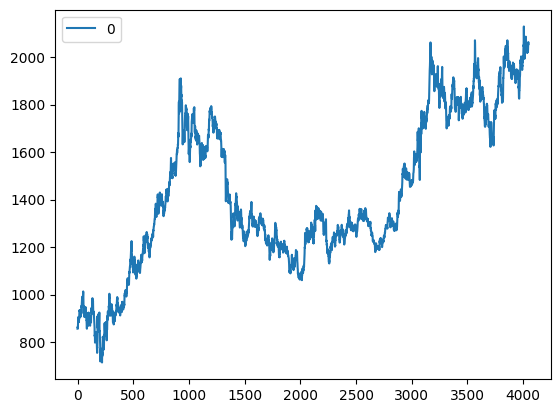

=====ADF Result=====
ADF Statistic: -1.203646
p-value: 0.672025
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567
0.6720253490290103 > 0.05
ADF Statistic: -1.203646 > Max Critical Values: 10% : -2.5671513419192578
By ADF Test, the time series is non_Stationary.
The Check score: 2
=====KPSS Result=====
KPSS Statistic: 1.014607
p-value: 0.010000
Critical values:
	10%: 0.119
	5%: 0.146
	2.5%: 0.176
	1%: 0.216
1.0146071807115937 < 0.05
ADF Statistic: 1.014607 > Max Critical Values: 1% : 0.216
By KPSS Test, the time series is non_Stationary.
The Check score: 2
========Final Result========
Overall Check Score: 4


<ipython-input-38-102a32dcca27>:39: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result_kpss_ct=kpss(series,regression="ct")


In [ ]:
lambda_transform = {'reciprocal':-1,'reciprocal sqrt':-0.5,'log':0,'sqrt':0.5,'no transform':1}

for trans in list(lambda_transform.keys()):
    Lambda = lambda_transform[trans]
    print(trans,'transformation','Lambda: %f' % Lambda)
    High_Transformed = boxcox(target_series,Lambda)
    High_Transformed = pd.DataFrame(High_Transformed)
    High_Transformed.plot()
    plt.show()
    check_stationary(High_Transformed.values)
    print('==================================================')


**Detrend by model fitting:**


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000187 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 4048, number of used features: 1
[LightGBM] [Info] Start training from score 1425.141478


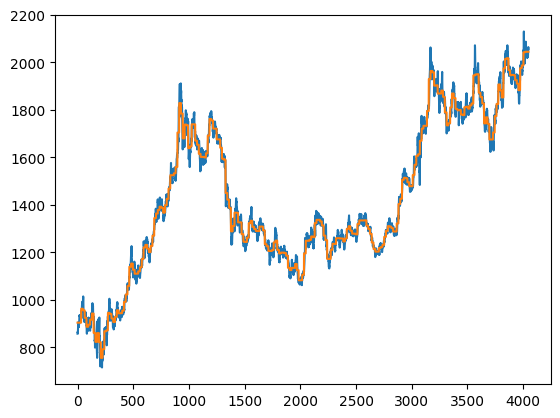

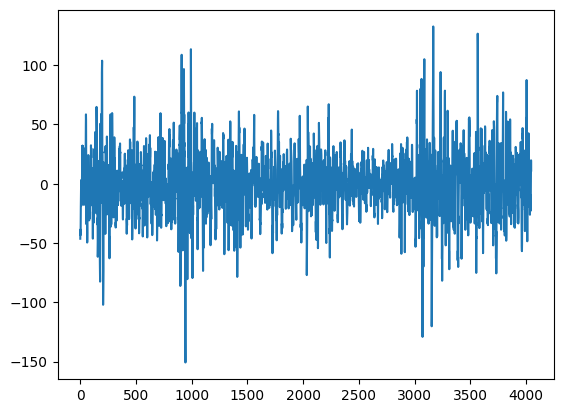

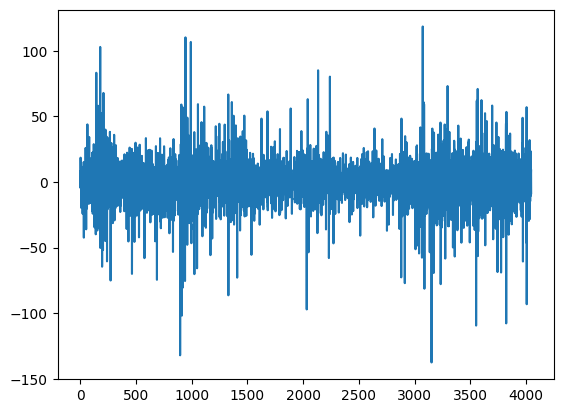

=====ADF Result=====
ADF Statistic: -16.377946
p-value: 0.000000
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567
By ADF Test, the time series is Stationary.
=====KPSS Result=====
KPSS Statistic: 0.003711
p-value: 0.100000
Critical values:
	10%: 0.119
	5%: 0.146
	2.5%: 0.176
	1%: 0.216
By KPSS Test, the time series is Stationary.
========Final Result========
Overall Check Score: 0


<ipython-input-38-102a32dcca27>:39: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result_kpss_ct=kpss(series,regression="ct")


In [ ]:
X = [i for i in range(0, len(target_series))]
X = np.reshape(X, (len(X), 1))
y = target_series.values
model = LGBMRegressor()
model.fit(X, y)
# calculate trend
trend = model.predict(X)


# plot trend
plt.plot(y)
plt.plot(trend)
plt.show()
# detrend
detrended = [y[i]-trend[i] for i in range(0, len(target_series))]
# plot detrended
plt.plot(detrended)
plt.show()

double_detrended = [detrended[i+1]-detrended[i] for i in range(0, len(target_series)-1)]
plt.plot(double_detrended)
plt.show()
check_stationary(detrended)

**Detrend by Differencing:**

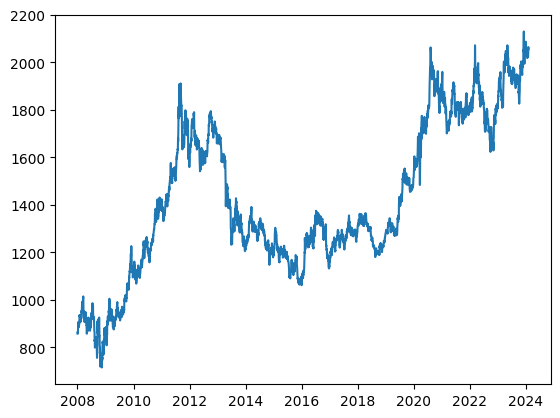

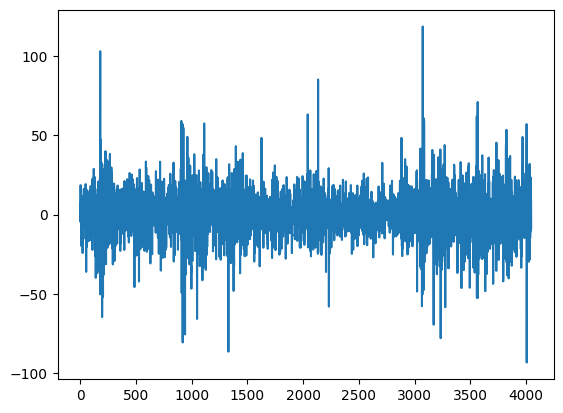

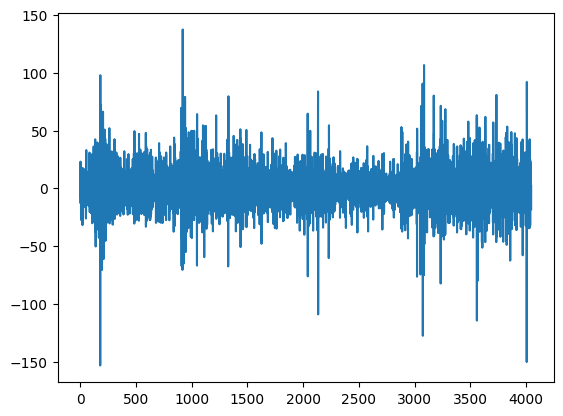

=====ADF Result=====
ADF Statistic: -20.114117
p-value: 0.000000
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567
By ADF Test, the time series is Stationary.
=====KPSS Result=====
KPSS Statistic: 0.077810
p-value: 0.100000
Critical values:
	10%: 0.119
	5%: 0.146
	2.5%: 0.176
	1%: 0.216
By KPSS Test, the time series is Stationary.
========Final Result========
Overall Check Score: 0


<ipython-input-38-102a32dcca27>:39: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result_kpss_ct=kpss(series,regression="ct")


In [ ]:
def diff(X):
    diff = list()
    for i in range(1, len(X)):
        value = X[i] - X[i - 1]
        diff.append(value)
    return diff

X = target_series
plt.plot(X)
plt.show()

plt.plot(diff(X))
plt.show()

plt.plot(diff(diff(X)))
plt.show()
check_stationary(diff(X))


**Seasonal Adjustment with Differencing:**

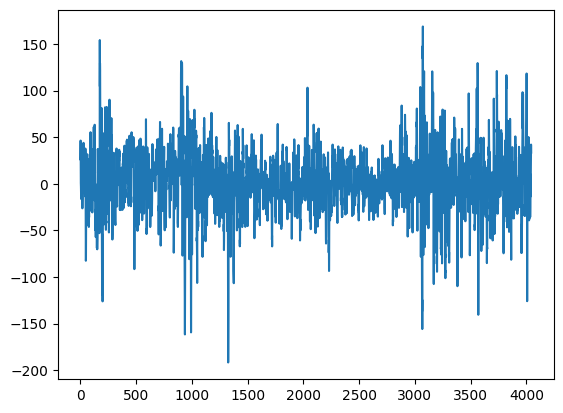

=====ADF Result=====
ADF Statistic: -11.295430
p-value: 0.000000
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567
By ADF Test, the time series is Stationary.
=====KPSS Result=====
KPSS Statistic: 0.088063
p-value: 0.100000
Critical values:
	10%: 0.119
	5%: 0.146
	2.5%: 0.176
	1%: 0.216
By KPSS Test, the time series is Stationary.
========Final Result========
Overall Check Score: 0
Help on function seasonal_decompose in module statsmodels.tsa.seasonal:

seasonal_decompose(x, model='additive', filt=None, period=None, two_sided=True, extrapolate_trend=0)
    Seasonal decomposition using moving averages.
    
    Parameters
    ----------
    x : array_like
        Time series. If 2d, individual series are in columns. x must contain 2
        complete cycles.
    model : {"additive", "multiplicative"}, optional
        Type of seasonal component. Abbreviations are accepted.
    filt : array_like, optional
        The filter coefficients for filtering out the seasonal component.
      

<ipython-input-38-102a32dcca27>:39: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result_kpss_ct=kpss(series,regression="ct")


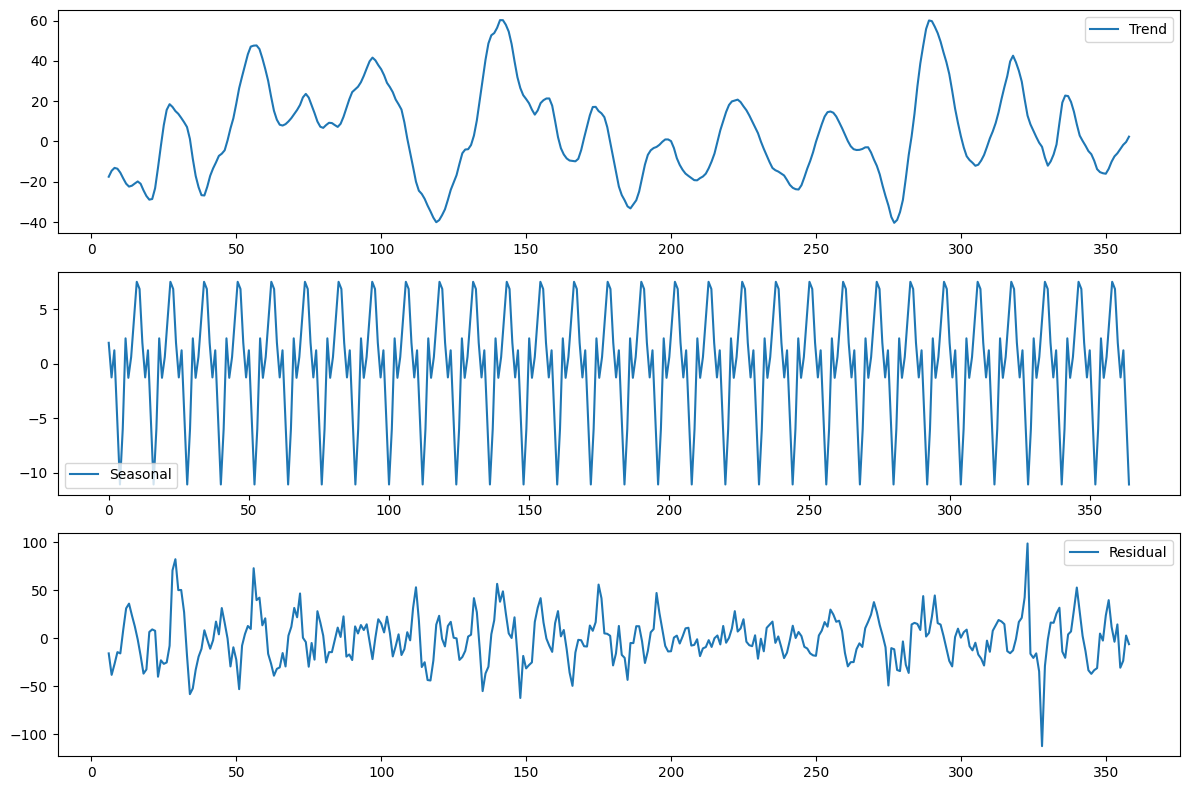

In [ ]:
X = target_series
diff = list()
season = 5  #try different value
for i in range(season, len(X)):
    value = X[i] - X[i - season]
    diff.append(value)
plt.plot(diff)
plt.show()
check_stationary(diff)

Y=diff[-365:]
# Perform time series decomposition
result = seasonal_decompose(Y, model='additive', period=12)

# Plot the original time series and its components
plt.figure(figsize=(12, 8))

help(seasonal_decompose)


plt.subplot(3, 1, 1)
plt.plot(result.trend, label='Trend')
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(result.seasonal, label='Seasonal')
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(result.resid, label='Residual')
plt.legend()

plt.tight_layout()
plt.show()


**Stationarity with rendement**

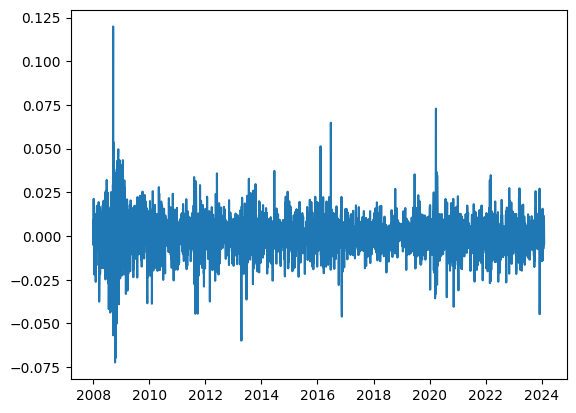

=====ADF Result=====
ADF Statistic: -16.103896
p-value: 0.000000
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567
By ADF Test, the time series is Stationary.
=====KPSS Result=====
KPSS Statistic: 0.080764
p-value: 0.100000
Critical values:
	10%: 0.119
	5%: 0.146
	2.5%: 0.176
	1%: 0.216
By KPSS Test, the time series is Stationary.
========Final Result========
Overall Check Score: 0


<ipython-input-38-102a32dcca27>:39: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result_kpss_ct=kpss(series,regression="ct")


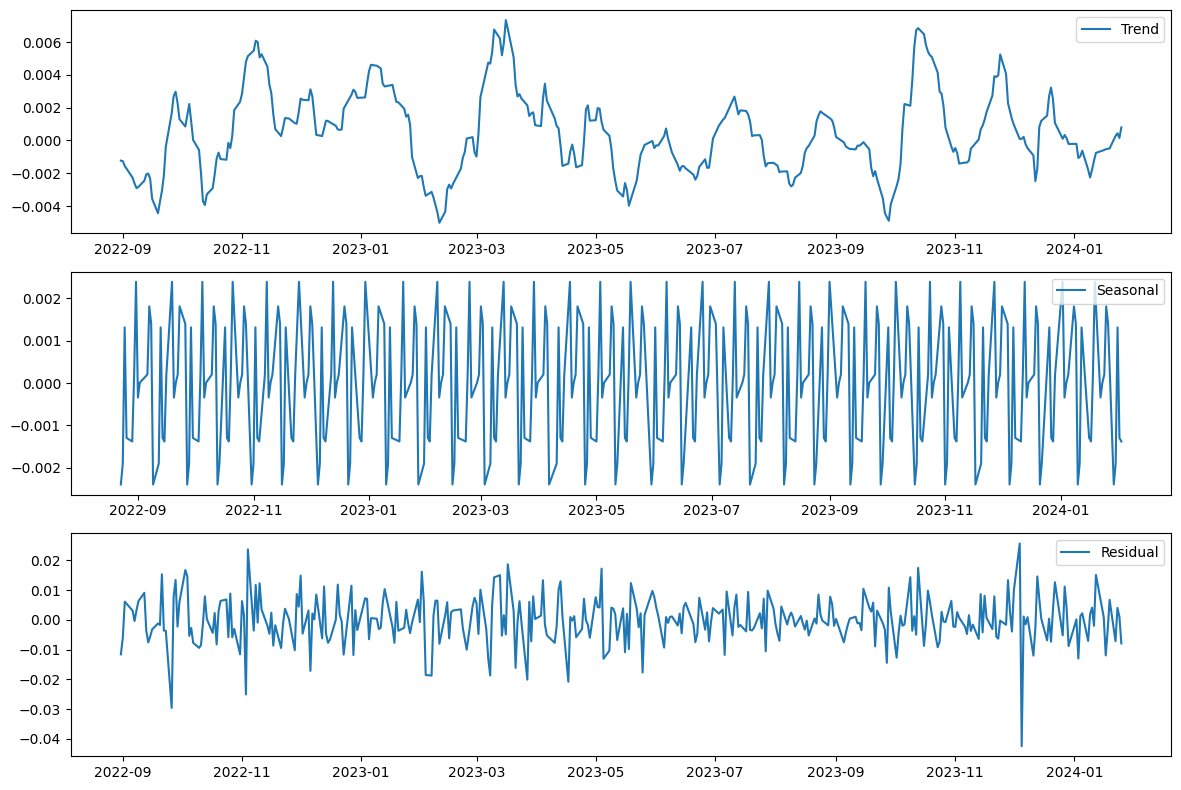

In [ ]:
series=target_series

X_Profit = np.log(series) - np.log(series.shift(1))
X_Profit = X_Profit.dropna()
plt.plot(X_Profit)
plt.show()
check_stationary(X_Profit)

X_Profit.to_csv("Rendement")


Y=X_Profit[-365:]
# Perform time series decomposition
result = seasonal_decompose(Y, model='additive', period=12)

# Plot the original time series and its components
plt.figure(figsize=(12, 8))



plt.subplot(3, 1, 1)
plt.plot(result.trend, label='Trend')
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(result.seasonal, label='Seasonal')
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(result.resid, label='Residual')
plt.legend()

plt.tight_layout()
plt.show()


 **Seasonal Adjustment with Modeling:**

<ipython-input-45-142e3027b12f>:5: RankWarning: Polyfit may be poorly conditioned
  coef = polyfit(X, y, degree)


Coefficients: [-1.99106349e-51  5.83157226e-47 -7.35898728e-43  5.06501727e-39
 -1.85953262e-35  1.36433477e-32  2.24728201e-28 -1.33208871e-24
  4.15177889e-21 -8.49070996e-18  1.20040601e-14 -1.18113501e-11
  7.94745545e-09 -3.51702009e-06  9.55759947e-04 -1.39426063e-01
  8.27472772e+00  8.06794398e+02]


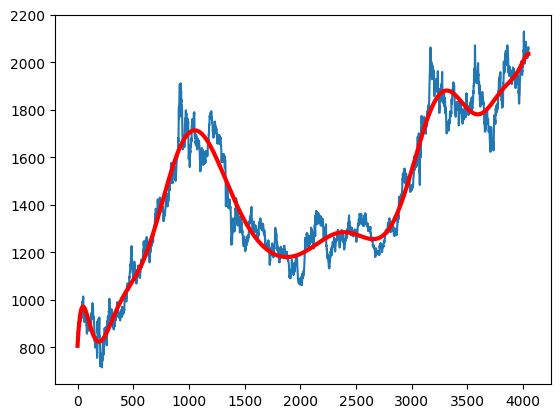

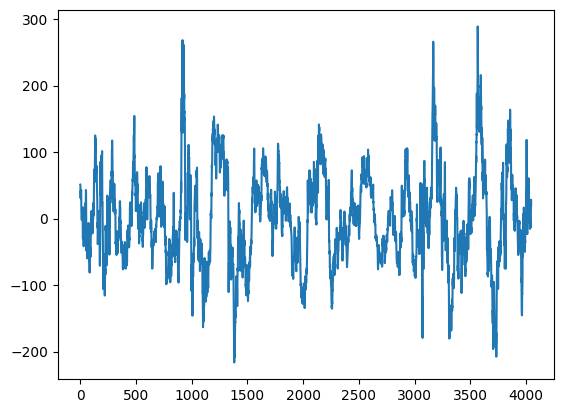

=====ADF Result=====
ADF Statistic: -6.904542
p-value: 0.000000
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567
By ADF Test, the time series is Stationary.
=====KPSS Result=====
KPSS Statistic: 0.017573
p-value: 0.100000
Critical values:
	10%: 0.119
	5%: 0.146
	2.5%: 0.176
	1%: 0.216
By KPSS Test, the time series is Stationary.
========Final Result========
Overall Check Score: 0


<ipython-input-38-102a32dcca27>:39: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result_kpss_ct=kpss(series,regression="ct")


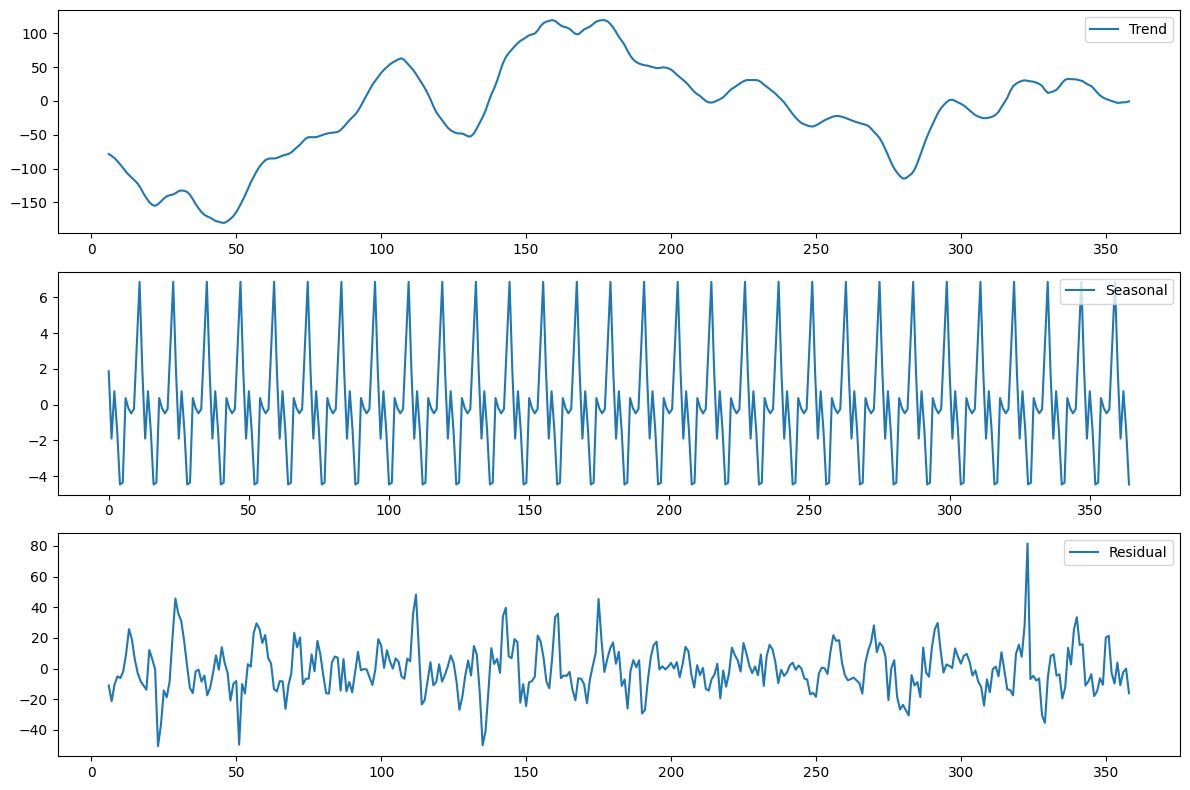

In [ ]:
series = target_series
X = [i%5500 for i in range(0, len(series))]
y = series.values
degree = 17
coef = polyfit(X, y, degree)
print('Coefficients: %s' % coef)
# create curve
curve = list()
for i in range(len(X)):
    value = coef[-1]
    for d in range(degree):
        value += X[i]**(degree-d) * coef[d]
    curve.append(value)
# plot curve over original data
plt.plot(series.values)
plt.plot(curve, color='red', linewidth=3)
plt.show()

# create seasonally adjusted
values = series.values
diff = list()
for i in range(len(values)):
    value = values[i] - curve[i]
    diff.append(value)
plt.plot(diff)
plt.show()
check_stationary(diff)


Y=diff[-365:]
# Perform time series decomposition
result = seasonal_decompose(Y, model='additive', period=12)

# Plot the original time series and its components
plt.figure(figsize=(12, 8))



plt.subplot(3, 1, 1)
plt.plot(result.trend, label='Trend')
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(result.seasonal, label='Seasonal')
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(result.resid, label='Residual')
plt.legend()

plt.tight_layout()
plt.show()

Parmis les séries stationnaires qu'on a pu générer on choisit de travailler sur le rendement logarithmique.



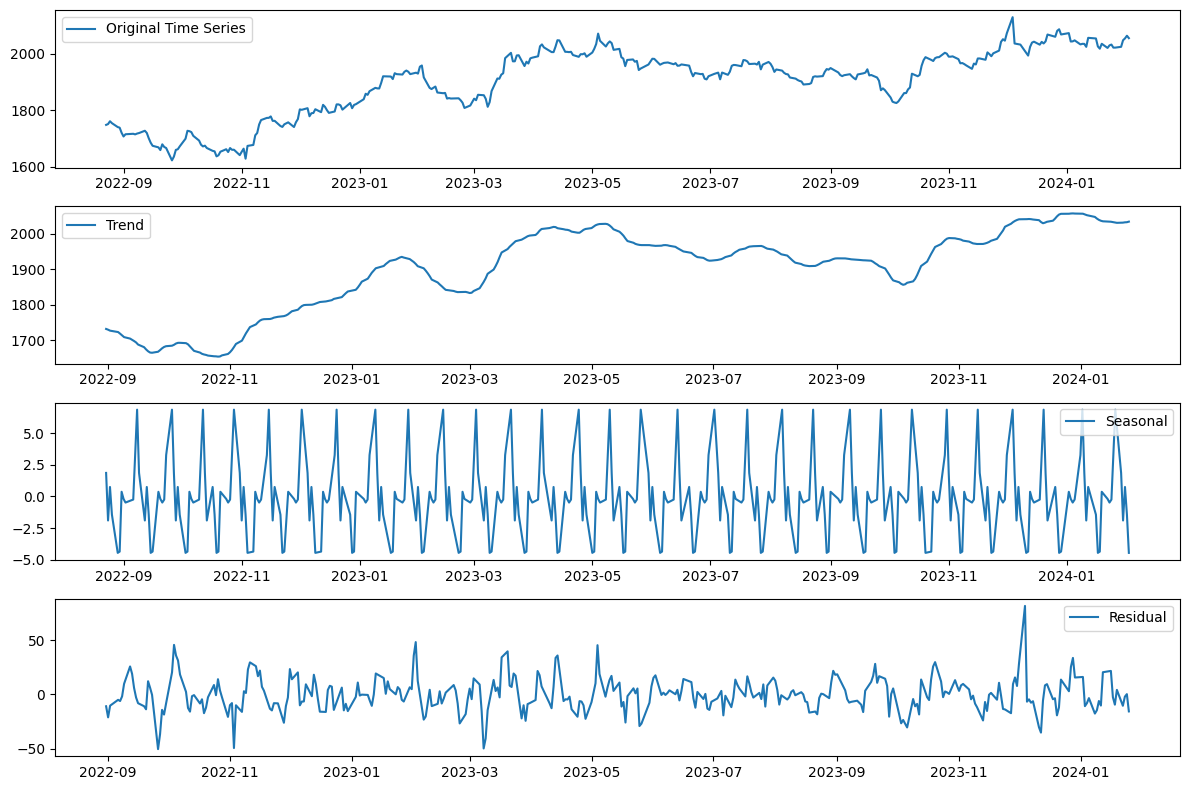

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
x = pd.Series(gold_data['High'].values, index=pd.date_range("2008-01-1", freq="D", periods=gold_data.shape[0]))
target_series = gold_data['High']
x = target_series[-365:]
# Perform time series decomposition
result = seasonal_decompose(x, model='additive', period=12)

# Plot the original time series and its components
plt.figure(figsize=(12, 8))

plt.subplot(4, 1, 1)
plt.plot(x, label='Original Time Series')
plt.legend()

plt.subplot(4, 1, 2)
plt.plot(result.trend, label='Trend')
plt.legend()

plt.subplot(4, 1, 3)
plt.plot(result.seasonal, label='Seasonal')
plt.legend()

plt.subplot(4, 1, 4)
plt.plot(result.resid, label='Residual')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
# Modèle AR
from statsmodels.tsa.ar_model import AutoReg
ar_model = AutoReg(x, lags=1)
ar_result = ar_model.fit()
print(ar_result.summary())

# Modèle MA
from statsmodels.tsa.arima.model import ARIMA
ma_model = ARIMA(x, order=(0,0,1))
ma_result = ma_model.fit()
print(ma_result.summary())

# Modèle ARMA
arma_model = ARIMA(x, order=(1,0,1))
arma_result = arma_model.fit()
print(arma_result.summary())

# Modèle ARIMA
arima_model = ARIMA(x, order=(1,1,1))
arima_result = arima_model.fit()
print(arima_result.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                            AutoReg Model Results                             
Dep. Variable:                   High   No. Observations:                  365
Model:                     AutoReg(1)   Log Likelihood               -1528.623
Method:               Conditional MLE   S.D. of innovations             16.128
Date:                Sun, 17 Mar 2024   AIC                           3063.245
Time:                        14:39:39   BIC                           3074.937
Sample:                             1   HQIC                          3067.892
                                  365                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         18.4041     13.619      1.351      0.177      -8.289      45.097
High.L1        0.9908      0.007    138.491      0.000       0.977       1.005
                                    Roots           

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                   High   No. Observations:                  365
Model:                 ARIMA(1, 0, 1)   Log Likelihood               -1535.493
Date:                Sun, 17 Mar 2024   AIC                           3078.987
Time:                        14:39:40   BIC                           3094.586
Sample:                             0   HQIC                          3085.186
                                - 365                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1900.5006     76.503     24.842      0.000    1750.558    2050.443
ar.L1          0.9916      0.007    136.907      0.000       0.977       1.006
ma.L1          0.0254      0.047      0.545      0.5

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                   High   No. Observations:                  365
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -1529.853
Date:                Sun, 17 Mar 2024   AIC                           3065.705
Time:                        14:39:40   BIC                           3077.397
Sample:                             0   HQIC                          3070.352
                                - 365                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1921      1.960     -0.098      0.922      -4.033       3.649
ma.L1          0.2148      1.967      0.109      0.913      -3.641       4.071
sigma2       261.9074     13.040     20.085      0.0

# Modèles de Cointégration

Quels sont les facteurs qui influencent le cours de l’or ?

**La situation géopolitique joue sur le cours de l’or**
L’histoire a régulièrement montré une hausse soudaine du cours de l’or tandis que des conflits faisaient rage. Par exemple, en 2011 lors des révolutions du Printemps arabe, l’or a atteint 1920 $ l’once. Des spéculateurs négocient même des contrats pour le futur en pariant sur les prochains évènements géopolitiques.

Par déduction, on se doute bien que le cours de l’or est également influencé par la force du Dollar américain.



**Le Dollar américain a-t-il une influence sur le cours de l’or ?**
Généralement, la cote de l’or est étudiée en Dollar US. La logique voudrait que si le Dollar est faible, le prix de l’or augmente et inversement. Malheureusement, ce procédé n’est pas toujours vérifié. L’or en Dollar est parfois confronté à l’or en Livres. Par exemple, depuis quelques décennies, le cours de l’or en Livres est bien plus important que celui du Dollar américain et ce, même lorsque la valeur du Dollar est en hausse.

**L’inflation, les taux d’intérêt et la bourse font des vagues sur le cours de l’or**
Comme l’inflation dévore petit à petit le pouvoir d’achat, elle a directement un impact sur le cours de l’or. Dans les années 2000, l’or a subi une forte perte de valeur puisque celle du Dollar a été divisée par deux au cours de cette période. Depuis, l’or a repris beaucoup de valeur au cours de la lente inflation américaine.

Les taux d’intérêt et les marchés boursiers n’ont pas réellement d’influence sur le cours de l’or. Sur les 50 dernières années, l’indice de corrélation mobile reste relativement proche de zéro.





L’achat en grande quantité d’or par la Chine éveille une certaine méfiance notamment au sujet des réserves d’or physique dans le futur.


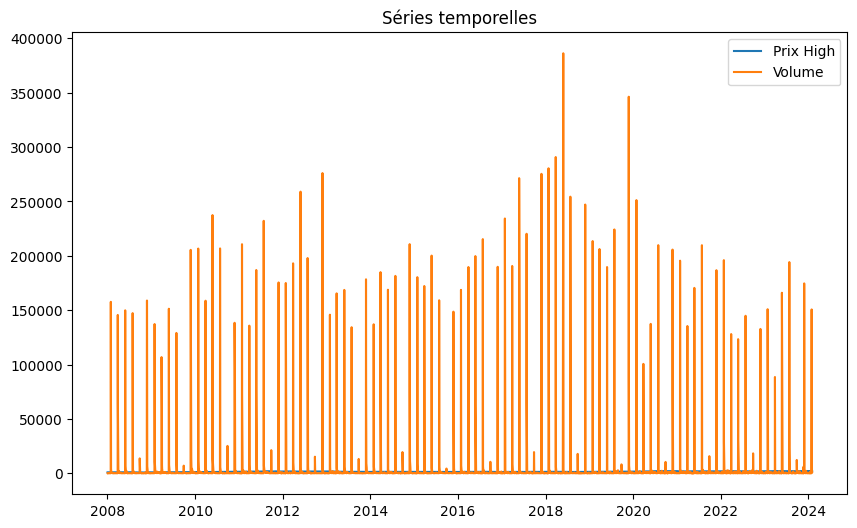

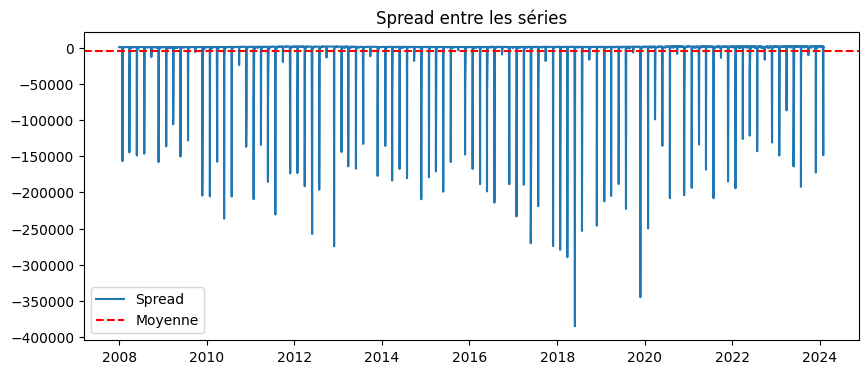


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=18.8929 , p=0.0000  , df_denom=4044, df_num=1
ssr based chi2 test:   chi2=18.9069 , p=0.0000  , df=1
likelihood ratio test: chi2=18.8629 , p=0.0000  , df=1
parameter F test:         F=18.8929 , p=0.0000  , df_denom=4044, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=9.9199  , p=0.0001  , df_denom=4041, df_num=2
ssr based chi2 test:   chi2=19.8644 , p=0.0000  , df=2
likelihood ratio test: chi2=19.8158 , p=0.0000  , df=2
parameter F test:         F=9.9199  , p=0.0001  , df_denom=4041, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=7.9315  , p=0.0000  , df_denom=4038, df_num=3
ssr based chi2 test:   chi2=23.8359 , p=0.0000  , df=3
likelihood ratio test: chi2=23.7659 , p=0.0000  , df=3
parameter F test:         F=7.9315  , p=0.0000  , df_denom=4038, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=6.0174  , p=0.

In [ ]:
# Étape 1 : Test de Dickey-Fuller augmenté (ADF) sur les séries temporelles individuelles
adf_result_target = adfuller(target_series)
adf_result_vol = adfuller(series_vol)

# Étape 2 : Test de Johansen pour la cointégration
johansen_result = coint_johansen(np.array([target_series, series_vol]).T, det_order=0, k_ar_diff=1)

# Étape 3 : Visualisation des séries temporelles et de la corrélation entre elles
plt.figure(figsize=(10, 6))
plt.plot(target_series, label='Prix High')
plt.plot(series_vol, label='Volume')
plt.title('Séries temporelles')
plt.legend()
plt.show()

# Étape 4 : Représentation graphique du spread (différence entre les séries)
spread = target_series - series_vol
plt.figure(figsize=(10, 4))
plt.plot(spread, label='Spread')
plt.axhline(spread.mean(), color='red', linestyle='--', label='Moyenne')
plt.title('Spread entre les séries')
plt.legend()
plt.show()

# Étape 5 : Test de Granger pour la causalité entre les séries
granger_test_result = grangercausalitytests(pd.concat([target_series, series_vol], axis=1), maxlag=5)

# Étape 6 : Analyse des résidus du modèle de cointégration pour évaluer l'illiquidité et son impact sur les prix
# Dans cet exemple, nous n'avons pas de modèle de cointégration spécifique, mais vous pouvez utiliser les résidus
# pour évaluer l'illiquidité en examinant les variations importantes dans les volumes par rapport aux prix.

# Affichage des résultats
print("Résultat du test de Dickey-Fuller augmenté (ADF) sur la série de prix high :")
print("Statistique ADF :", adf_result_target[0])
print("p-valeur :", adf_result_target[1])
print("\nRésultat du test de Dickey-Fuller augmenté (ADF) sur la série de volumes :")
print("Statistique ADF :", adf_result_vol[0])
print("p-valeur :", adf_result_vol[1])
print("\nRésultat du test de Johansen pour la cointégration :")
print("Statistique de trace :", johansen_result.trace_stat)
print("p-valeur (statistique de trace) :", johansen_result.trace_stat_crit_vals)
print("Statistique maximale de valeur propre :", johansen_result.max_eig_stat)
print("p-valeur (statistique maximale de valeur propre) :", johansen_result.max_eig_stat_crit_vals)
print("Vecteurs de cointégration :", johansen_result.eig)
print("\nRésultat du test de Granger pour la causalité entre les séries :")
print(granger_test_result)

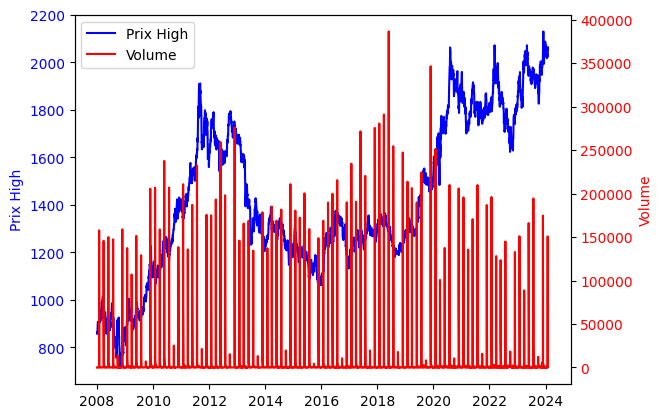

In [ ]:
# Créer une nouvelle figure et un seul axe y
fig, ax1 = plt.subplots()

# Tracez la série pour le prix high sur le premier axe y (à gauche)
ax1.plot(target_series, color='blue', label='Prix High')
ax1.set_ylabel('Prix High', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Créez un deuxième axe y pour la série de volume (à droite)
ax2 = ax1.twinx()

# Tracez la série pour le volume sur le deuxième axe y (à droite)
ax2.plot(series_vol, color='red', label='Volume')
ax2.set_ylabel('Volume', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Ajoutez une légende combinée pour les deux séries
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper left')

# Affichez le plot
plt.show()

In [ ]:
symbol = "USDEUR=X"
# Récupération des données sur le taux d'inflation
exchange_rate = yf.download(symbol, start="2008-01-01", end="2024-02-04")


exchange_rate = exchange_rate[exchange_rate.Open !=0]
exchange_rate = exchange_rate[exchange_rate.High !=0]
exchange_rate = exchange_rate[exchange_rate.Low !=0]
exchange_rate = exchange_rate[exchange_rate.Close !=0]

#exchange_rate
X_Profit

[*********************100%%**********************]  1 of 1 completed


Date
2008-01-03    0.008936
2008-01-04    0.000000
2008-01-07   -0.005329
2008-01-08    0.021262
2008-01-09    0.006348
                ...   
2024-01-29    0.001383
2024-01-30    0.011439
2024-01-31    0.003168
2024-02-01    0.004612
2024-02-02   -0.004174
Name: High, Length: 4047, dtype: float64

In [ ]:
exchange_rate_high = exchange_rate['High']



merged = pd.merge(exchange_rate_high, X_Profit, how='inner', left_index=True, right_index=True)

merged

,High_x,High_y
Date,,
2008-01-03,0.68055,0.008936
2008-01-04,0.68032,0.000000
2008-01-07,0.68180,-0.005329
2008-01-08,0.64392,0.021262
2008-01-09,0.68292,0.006348
...,...,...
2024-01-29,0.92617,0.001383
2024-01-30,0.92484,0.011439
2024-01-31,0.92527,0.003168


In [ ]:
result = coint(merged['High_x'],merged['High_y'])
#johansen_result = coint_johansen(np.array(merged).T, det_order=0, k_ar_diff=1)
johansen_result = coint_johansen(merged, det_order=0, k_ar_diff=1)




help(coint_johansen)

Help on function coint_johansen in module statsmodels.tsa.vector_ar.vecm:

coint_johansen(endog, det_order, k_ar_diff)
    Johansen cointegration test of the cointegration rank of a VECM
    
    Parameters
    ----------
    endog : array_like (nobs_tot x neqs)
        Data to test
    det_order : int
        * -1 - no deterministic terms
        * 0 - constant term
        * 1 - linear trend
    k_ar_diff : int, nonnegative
        Number of lagged differences in the model.
    
    Returns
    -------
    result : JohansenTestResult
        An object containing the test's results. The most important attributes
        of the result class are:
    
        * trace_stat and trace_stat_crit_vals
        * max_eig_stat and max_eig_stat_crit_vals
    
    Notes
    -----
    The implementation might change to make more use of the existing VECM
    framework.
    
    See Also
    --------
    statsmodels.tsa.vector_ar.vecm.select_coint_rank
    
    References
    ----------
    .. [1] L

In [ ]:
# Afficher les résultats du test de Johansen
print("\nRésultat du test de Johansen pour la cointégration :")
print("Statistique de trace :", johansen_result.trace_stat)
print("p-valeur (statistique de trace) :", johansen_result.trace_stat_crit_vals)
print("Statistique maximale de valeur propre :", johansen_result.max_eig_stat)
#print("p-valeur (statistique maximale de valeur propre) :", johansen_result.lr2_crit)
print("Vecteurs de cointégration :", johansen_result.max_eig_stat_crit_vals)


Résultat du test de Johansen pour la cointégration :
Statistique de trace : [2751.02614577 1187.4086921 ]
p-valeur (statistique de trace) : [[13.4294 15.4943 19.9349]
 [ 2.7055  3.8415  6.6349]]
Statistique maximale de valeur propre : [1563.61745367 1187.4086921 ]
Vecteurs de cointégration : [[12.2971 14.2639 18.52  ]
 [ 2.7055  3.8415  6.6349]]


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001054. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:     18,   Neg. LLF: 157987.12972542367
Iteration:      2,   Func. Count:     37,   Neg. LLF: -4437.220181703729
Iteration:      3,   Func. Count:     55,   Neg. LLF: -9915.669753841512
Iteration:      4,   Func. Count:     75,   Neg. LLF: -11854.393376331474
Iteration:      5,   Func. Count:     94,   Neg. LLF: -11084.291081286852
Iteration:      6,   Func. Count:    113,   Neg. LLF: 8402.678779416306
Iteration:      7,   Func. Count:    131,   Neg. LLF: -12985.986600639582
Optimization terminated successfully    (Exit mode 0)
            Current function value: -12985.98660037395
            Iterations: 11
            Function evaluations: 131
            Gradient evaluations: 7


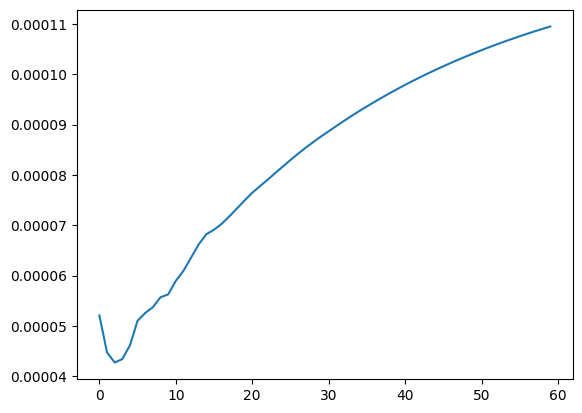

In [ ]:
train,test = X_Profit[:-60],X_Profit[-60:]
# define model
model = arch_model(train, mean='Zero', vol='ARCH', p=15)
# fit model
model_fit = model.fit()
# forecast the test set
yhat = model_fit.forecast(horizon=60)
# plot the actual variance
Var_test = np.var(test)
#plt.plot(Var_test)
# plot forecast variance
plt.plot(yhat.variance.values[-1, :])
plt.show()

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001054. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Optimization terminated successfully    (Exit mode 0)
            Current function value: -12998.983247512631
            Iterations: 6
            Function evaluations: 18
            Gradient evaluations: 2
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                   High   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                12999.0
Distribution:                  Normal   AIC:                          -25990.0
Method:            Maximum Likelihood   BIC:                          -25964.8
                                        No. Observations:                 3987
Date:                Sun, Mar 17 2024   Df Residuals:                     3986
Time:                        14:41:29   Df Model:                            1
                                 Mean Model                                 
   

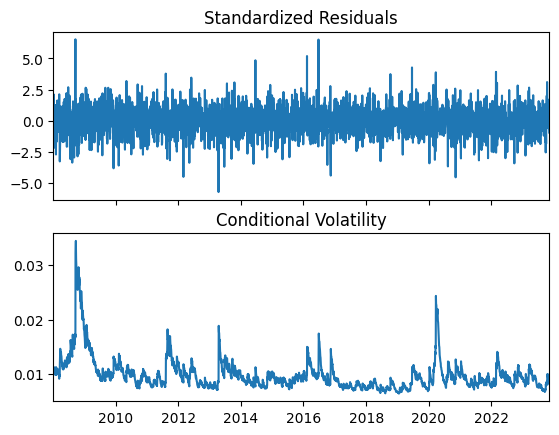

In [ ]:
model = arch_model(X_Profit[:-60], p = 1,vol='GARCH', q = 1)
model_fit = model.fit(update_freq=5)
print(model_fit.summary())
model_fit.plot(); print()

# Amélioration

EWMA



<Axes: xlabel='Date'>

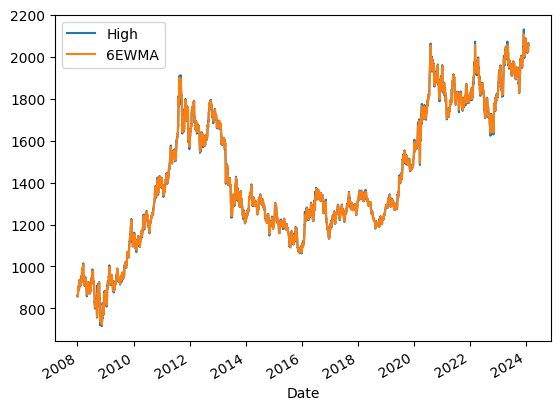

In [ ]:
df = gold_data
df['6EWMA'] = df['High'].ewm(span=2).mean()
df[['High','6EWMA']].plot()



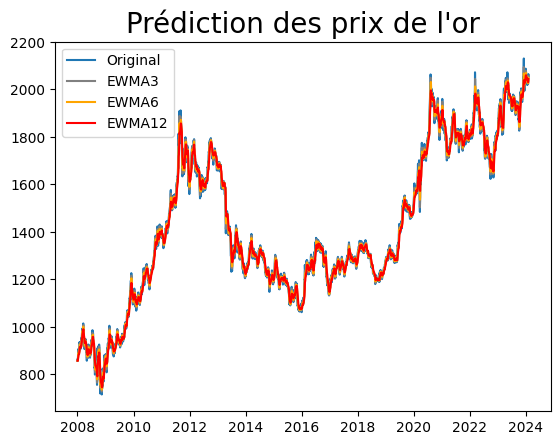

In [ ]:

df['EWMA3'] = df['High'].ewm(span=3, adjust=False).mean()
df['EWMA6'] = df['High'].ewm(span=6, adjust=False).mean()
df['EWMA12'] = df['High'].ewm(span=12, adjust=False).mean()

# Plot
plt.title('Prédiction des prix de l\'or', size=20)
plt.plot(df['High'], label='Original')
plt.plot(df['EWMA3'], color='gray', label='EWMA3')
plt.plot(df['EWMA6'], color='orange', label='EWMA6')
plt.plot(df['EWMA12'], color='red', label='EWMA12')
plt.legend();

In [ ]:
# Calculer les prédictions pour chaque modèle EWMA
predictions_EWMA3 = df['EWMA3']
predictions_EWMA6 = df['EWMA6']
predictions_EWMA12 = df['EWMA12']

# Calculer les métriques de performance pour chaque modèle
rmse_EWMA3 = np.sqrt(mean_squared_error(df['High'], predictions_EWMA3))
mae_EWMA3 = mean_absolute_error(df['High'], predictions_EWMA3)
r2_EWMA3 = 1 - (np.sum((df['High'] - predictions_EWMA3)**2) / np.sum((df['High'] - np.mean(df['High']))**2))

rmse_EWMA6 = np.sqrt(mean_squared_error(df['High'], predictions_EWMA6))
mae_EWMA6 = mean_absolute_error(df['High'], predictions_EWMA6)
r2_EWMA6 = 1 - (np.sum((df['High'] - predictions_EWMA6)**2) / np.sum((df['High'] - np.mean(df['High']))**2))

rmse_EWMA12 = np.sqrt(mean_squared_error(df['High'], predictions_EWMA12))
mae_EWMA12 = mean_absolute_error(df['High'], predictions_EWMA12)
r2_EWMA12 = 1 - (np.sum((df['High'] - predictions_EWMA12)**2) / np.sum((df['High'] - np.mean(df['High']))**2))

# Afficher les métriques
print("Métriques de performance pour le modèle EWMA avec span=3 :")
print("RMSE:", rmse_EWMA3)
print("MAE:", mae_EWMA3)
print("R^2:", r2_EWMA3)
print()
print("Métriques de performance pour le modèle EWMA avec span=6 :")
print("RMSE:", rmse_EWMA6)
print("MAE:", mae_EWMA6)
print("R^2:", r2_EWMA6)
print()
print("Métriques de performance pour le modèle EWMA avec span=12 :")
print("RMSE:", rmse_EWMA12)
print("MAE:", mae_EWMA12)
print("R^2:", r2_EWMA12)

Métriques de performance pour le modèle EWMA avec span=3 :
RMSE: 8.436199341620043
MAE: 6.071614587987186
R^2: 0.9993070630636619

Métriques de performance pour le modèle EWMA avec span=6 :
RMSE: 14.998806618198937
MAE: 10.976445541249523
R^2: 0.9978096503053813

Métriques de performance pour le modèle EWMA avec span=12 :
RMSE: 23.134361601934586
MAE: 17.234932929870318
R^2: 0.9947890718603538


# ETS


In [ ]:
df_train = gold_data['High']['2008':'2022']
df_test = gold_data['High']['2022':]

# fit in statsmodels
model = ETSModel(
    df_train,
    error="add",
    trend="add",
    seasonal="add",
    damped_trend=True,
    seasonal_periods=20,
)
fit = model.fit()
print(fit.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                 ETS Results                                  
Dep. Variable:                   High   No. Observations:                 3774
Model:                      ETS(AAdA)   Log Likelihood              -15274.757
Date:                Fri, 01 Mar 2024   AIC                          30603.514
Time:                        18:18:09   BIC                          30771.883
Sample:                             0   HQIC                         30663.373
                               - 3774   Scale                          191.877
Covariance Type:               approx                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
smoothing_level         0.9999      0.013     76.565      0.000       0.974       1.025
smoothing_trend         0.0304        nan        nan        nan         nan         nan
smoothing_season

In [ ]:
pred = fit.get_prediction(start="2008", end="2022")
df = pred.summary_frame(alpha=0.05)
simulated = fit.simulate(anchor="end", nsimulations=191, repetitions=100)


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


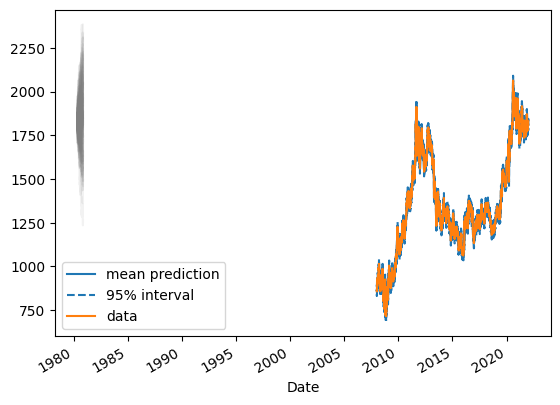

In [ ]:
for i in range(simulated.shape[1]):
    simulated.iloc[:, i].plot(label="_", color="gray", alpha=0.1)
df["mean"].plot(label="mean prediction")
df["pi_lower"].plot(linestyle="--", color="tab:blue", label="95% interval")
df["pi_upper"].plot(linestyle="--", color="tab:blue", label="_")
pred.endog.plot(label="data")
plt.legend()